In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib as plt
import os
import pathlib
import PIL

In [4]:
! pip install matplotlib

In [2]:
data_dir = "Fine_Tuning_dataset"
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2157


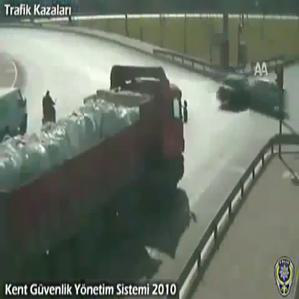

In [4]:
Accident = list(data_dir.glob('Accident/*'))
PIL.Image.open(str(Accident[0]))

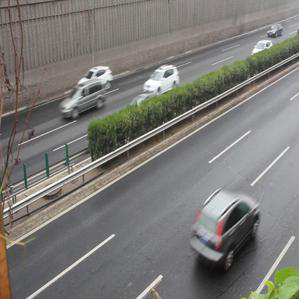

In [5]:
NoNAccident = list(data_dir.glob('Non-Accident/*'))
PIL.Image.open(str(NoNAccident[0]))

In [6]:
batch_size = 32
img_height = 299
img_width = 299

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2157 files belonging to 2 classes.
Using 1726 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2157 files belonging to 2 classes.
Using 431 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Accident', 'Non-Accident']


In [10]:
import matplotlib.pyplot as plt

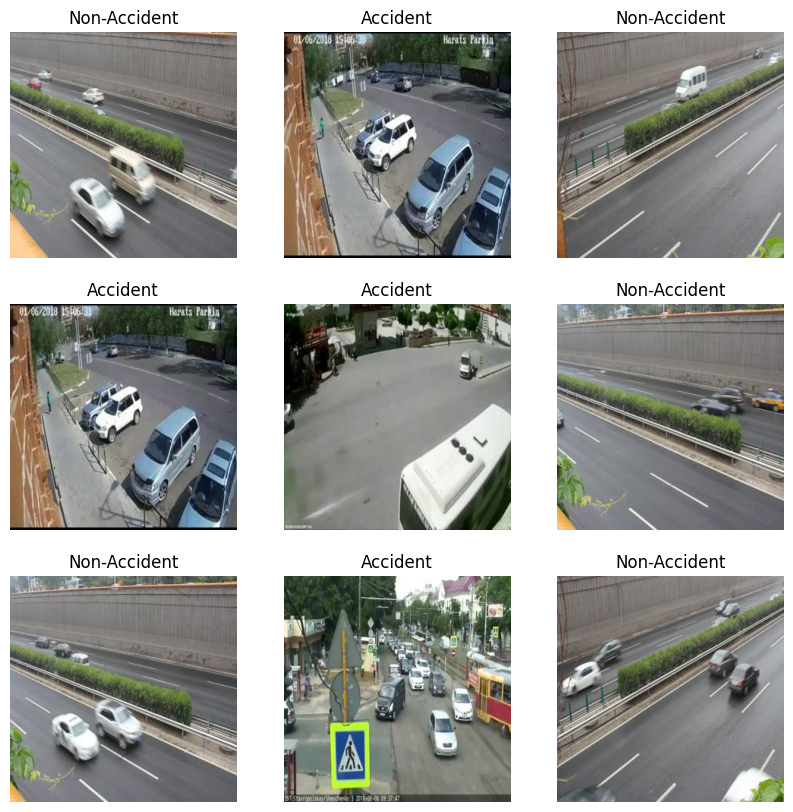

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 299, 299, 3)
(32,)


In [13]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 12
Number of test batches: 2


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

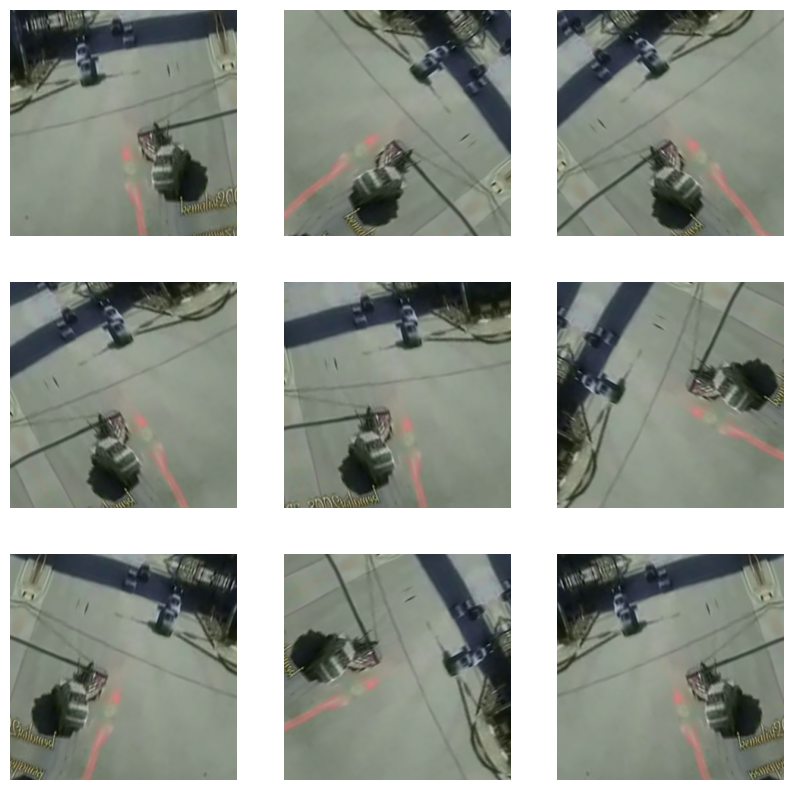

In [17]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [18]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [19]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [20]:
IMG_SIZE = (299, 299)
IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE

(299, 299, 3)

In [21]:
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [22]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 2048)


In [23]:
base_model.trainable = False

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [25]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [26]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              (metrics=['accuracy']))

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [29]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 8s 360ms/step - loss: 0.8838 - accuracy: 0.5041
initial loss: 0.88
initial accuracy: 0.50


In [30]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
54/54 [==============================] - 27s 402ms/step - loss: 0.7464 - accuracy: 0.5203 - val_loss: 0.6421 - val_accuracy: 0.6022
Epoch 2/10
54/54 [==============================] - 19s 349ms/step - loss: 0.5439 - accuracy: 0.6790 - val_loss: 0.4950 - val_accuracy: 0.8447
Epoch 3/10
54/54 [==============================] - 19s 350ms/step - loss: 0.4174 - accuracy: 0.8163 - val_loss: 0.3969 - val_accuracy: 0.9319
Epoch 4/10
54/54 [==============================] - 19s 351ms/step - loss: 0.3442 - accuracy: 0.8830 - val_loss: 0.3377 - val_accuracy: 0.9755
Epoch 5/10
54/54 [==============================] - 19s 351ms/step - loss: 0.2891 - accuracy: 0.9137 - val_loss: 0.2889 - val_accuracy: 0.9809
Epoch 6/10
54/54 [==============================] - 19s 351ms/step - loss: 0.2486 - accuracy: 0.9415 - val_loss: 0.2619 - val_accuracy: 0.9864
Epoch 7/10
54/54 [==============================] - 19s 352ms/step - loss: 0.2216 - accuracy: 0.9380 - val_loss: 0.2369 - val_accuracy: 0.9864

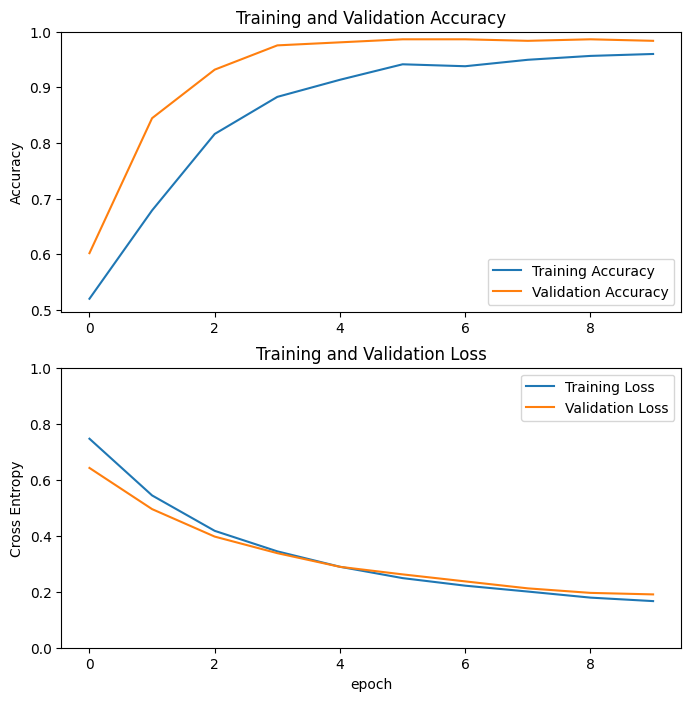

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 240

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [35]:
len(model.trainable_variables)

42

In [36]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20


54/54 [==============================] - 33s 467ms/step - loss: 0.0525 - accuracy: 0.9826 - val_loss: 0.0226 - val_accuracy: 0.9946
Epoch 11/20
54/54 [==============================] - 23s 425ms/step - loss: 0.0051 - accuracy: 0.9994 - val_loss: 0.0081 - val_accuracy: 0.9946
Epoch 12/20
54/54 [==============================] - 23s 426ms/step - loss: 0.0073 - accuracy: 0.9983 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 13/20
54/54 [==============================] - 23s 427ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 14/20
54/54 [==============================] - 23s 428ms/step - loss: 1.7803e-04 - accuracy: 1.0000 - val_loss: 4.3066e-04 - val_accuracy: 1.0000
Epoch 15/20
54/54 [==============================] - 23s 427ms/step - loss: 7.3856e-05 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 16/20
54/54 [==============================] - 23s 427ms/step - loss: 5.3097e-05 - accuracy: 1.0000 - val_loss: 2.5567e-04 - val_a

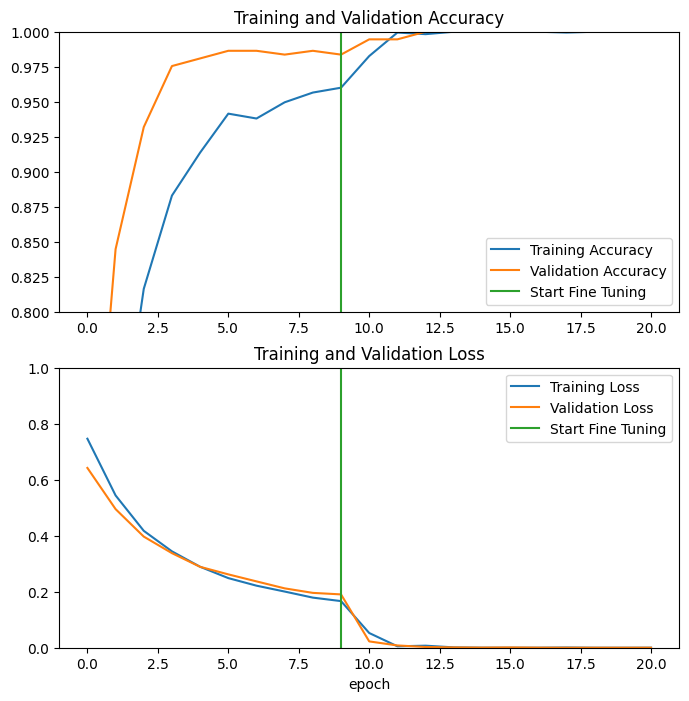

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0]
Labels:
 [1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0]


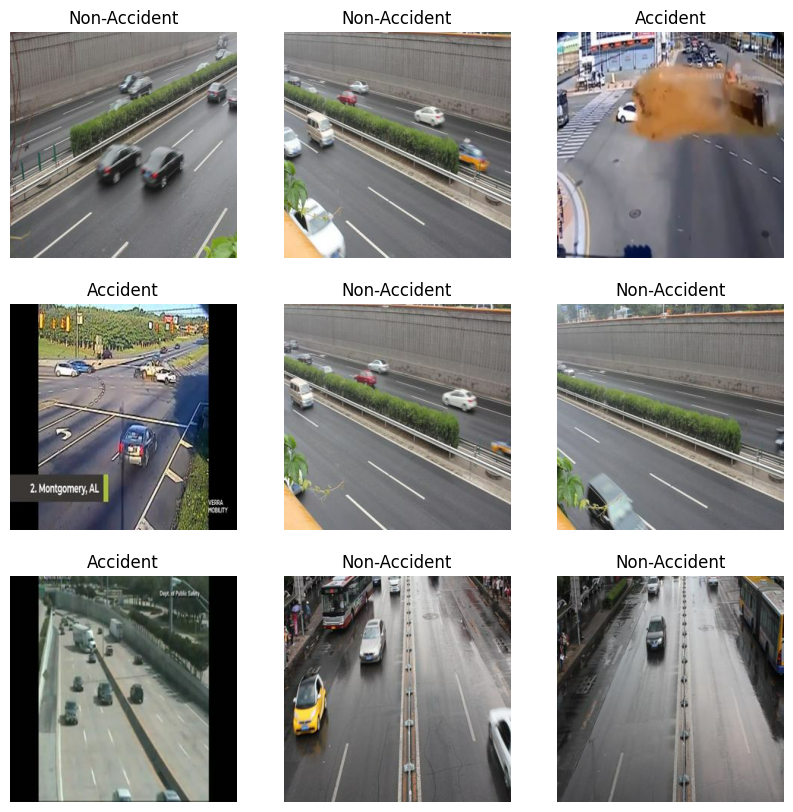

In [55]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [39]:
model.save("inceptionV3_FineTUned_Accident_Non-Accident.h5")

In [40]:
new_model = tf.keras.models.load_model("inceptionV3_FineTUned_Accident_Non-Accident.h5")

In [41]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

Predictions:
 [0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1]
Labels:
 [0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1]


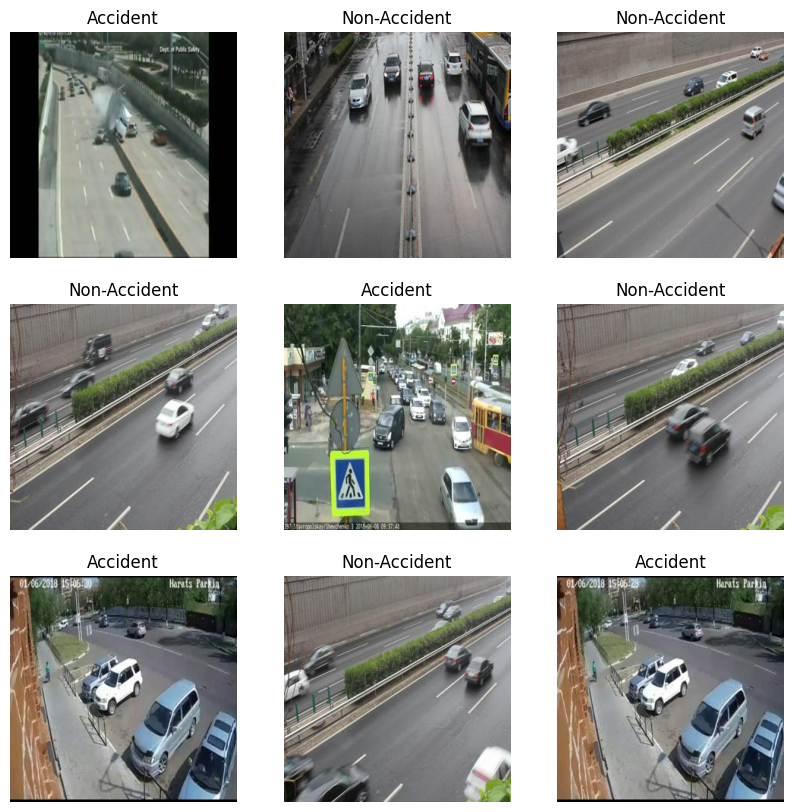

In [42]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = new_model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

- cannot cut of the last 3 layers (classification head) to apply feature extraction (i get graph disconnted error)


In [43]:
desired_weights = new_model.get_layer("inception_v3").get_weights()

In [44]:
import pickle

In [45]:
with open('InceptionV3_weights_Fine-Tuned_Accident_Non-Accident.pkl', 'wb') as f:
    pickle.dump(desired_weights, f)

In [46]:
with open('InceptionV3_weights_Fine-Tuned_Accident_Non-Accident.pkl', 'rb') as f:
    desired_weights_loaded = pickle.load(f)

In [47]:
len(desired_weights_loaded)

376

In [48]:
original_weights = base_model.get_weights()

In [49]:
len(original_weights)

376

In [51]:
base_model.set_weights(desired_weights_loaded)

In [52]:
img = tf.keras.preprocessing.image.load_img("Fine_Tuning_data/Accident/1.jpg", target_size=(299, 299))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [53]:
features = base_model.predict(x)

1/1 [==============================] - 3s 3s/step


In [54]:
features.shape

(1, 8, 8, 2048)